Analyze my band's data from YouTube

1. Import the libraries

In [1]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn import linear_model

2. Type the API keys

In [2]:
api_key = "YOUR_API_KEY"
channel_id = "YOUR_CHANNEL_ID"

3. Create a function for track statistics datas

In [3]:
def get_video_details(video_id):

    url_video_stats = f"https://www.googleapis.com/youtube/v3/videos?id={video_id}&part=statistics&key={api_key}"
    response_video_stats = requests.get(url_video_stats).json()

    view_count = int(response_video_stats["items"][0]["statistics"]["viewCount"])
    like_count = int(response_video_stats["items"][0]["statistics"]["likeCount"])
    comment_count = response_video_stats["items"][0]["statistics"]["commentCount"]

    return view_count, like_count, comment_count

4. Create a function for basic track datas

In [4]:
def get_videos(df):
    pageToken = ""
    while 1:
        url = f"https://www.googleapis.com/youtube/v3/search?key={api_key}&channelId={channel_id}&part=snippet,id&order=date&maxResults=10000&{pageToken}"

        response = requests.get(url).json()
        time.sleep(1) #give it a second before starting the for loop
        for video in response["items"]:
            if video["id"]["kind"] == "youtube#video":
                video_id = video["id"]["videoId"]
                video_title = video["snippet"]["title"]
                video_title = str(video_title).replace("&","")
                upload_date = video["snippet"]["publishedAt"]
                upload_date = str(upload_date).split("T")[0]
                view_count, like_count, comment_count = get_video_details(video_id)

                temp_df = pd.DataFrame([[video_id, video_title, upload_date, view_count, like_count, comment_count]],
                    columns=["video_id", "video_title", "upload_date", "view_count", "like_count", "comment_count"])
                df = pd.concat([df, temp_df], ignore_index=True)

        try:
            if response["nextPageToken"] != None:
                pageToken = "pageToken=" + response["nextPageToken"]

        except:
            break


    return df

5. Build the dataframe

In [5]:
youtubeData = pd.DataFrame(columns=["video_id","video_title","upload_date","view_count","like_count","comment_count"]) 
youtubeData = get_videos(youtubeData)
youtubeData = youtubeData.sort_values(by=["view_count", "like_count"]).drop_duplicates()

6. Create a Linear Regression Model

In [6]:
linReg = linear_model.LinearRegression()
linReg.fit(youtubeData[["view_count"]], youtubeData["like_count"]).get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

7. Data Visualization

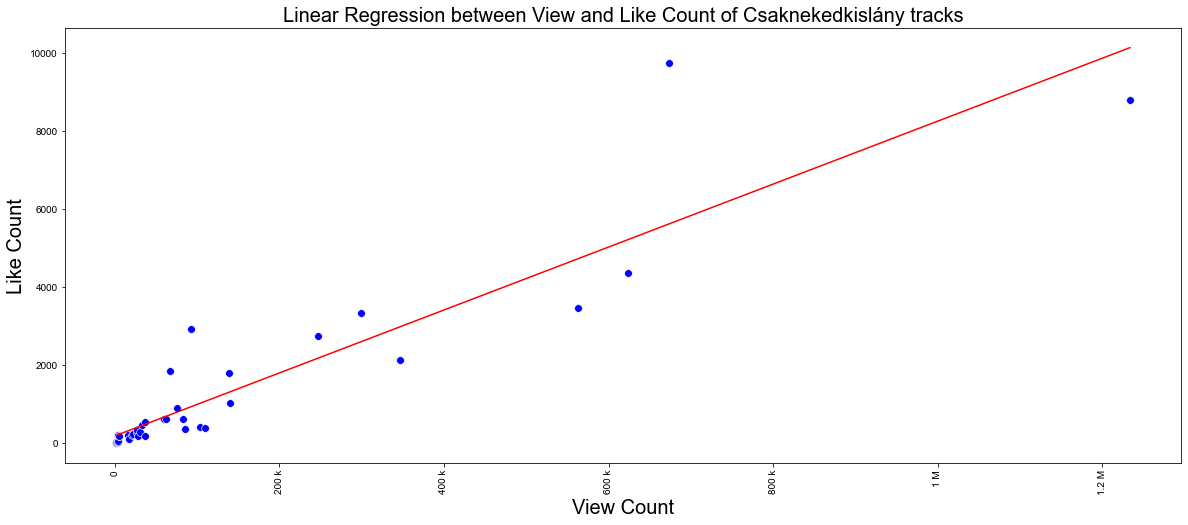

In [7]:
fig, axes = plt.subplots(figsize=(20,8))
sns.set_style("darkgrid")
sns.scatterplot(data= youtubeData, x="view_count", y="like_count", s=60, color = "blue")
plt.plot(youtubeData["view_count"], linReg.predict(youtubeData[["view_count"]]), color="red")
plt.xlabel("View Count", fontsize=20)
plt.ylabel("Like Count", fontsize=20)
plt.title("Linear Regression between View and Like Count of Csaknekedkislány tracks", fontsize=20)
plt.xticks(rotation=90)
axes.xaxis.set_major_formatter(ticker.EngFormatter(unit=''))
plt.show()